In [1]:
%load_ext autoreload
%autoreload 2
import pathlib

import torch
from einops import rearrange
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    kspace = torch.view_as_complex(kspace)
    masked_kspace = torch.view_as_complex(masked_kspace)
    csm = torch.view_as_complex(csm)
    mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch -> ch h w")
    return kspace, masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/Users/chunxuguo/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

In [2]:
import os

import torchopt

from ese5934_project.models.fields import Grid
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

field = Grid((640, 368))
optimizer = torchopt.adam()
kspace, masked_kspace, mask, csm = dataset[15]

[2024-02-15 02:59:30,974] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


Done.


In [3]:
print(masked_kspace.shape, mask.shape, csm.shape)

torch.Size([15, 640, 368]) torch.Size([1, 1, 368]) torch.Size([15, 640, 368])


In [6]:
image_list = reconstruct(
    field,
    kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=200,
    device="cpu",
)

iteration 0, loss: 0.0008093878859654069
iteration 0
iteration 1, loss: 0.034521978348493576
iteration 2, loss: 0.009218785911798477
iteration 3, loss: 0.019786452874541283
iteration 4, loss: 0.01904725283384323
iteration 5, loss: 0.01050261314958334
iteration 6, loss: 0.006669461727142334
iteration 7, loss: 0.008473612368106842
iteration 8, loss: 0.010252340696752071
iteration 9, loss: 0.008829375728964806
iteration 10, loss: 0.006002787034958601
iteration 11, loss: 0.004524402320384979
iteration 12, loss: 0.004869980271905661
iteration 13, loss: 0.005531712435185909
iteration 14, loss: 0.005231908522546291
iteration 15, loss: 0.004191151354461908
iteration 16, loss: 0.0033556614071130753
iteration 17, loss: 0.0031702877022325993
iteration 18, loss: 0.0033117439597845078
iteration 19, loss: 0.0032712239772081375
iteration 20, loss: 0.002919010818004608
iteration 21, loss: 0.002496904693543911
iteration 22, loss: 0.0022565179970115423
iteration 23, loss: 0.002218432491645217
iteration 

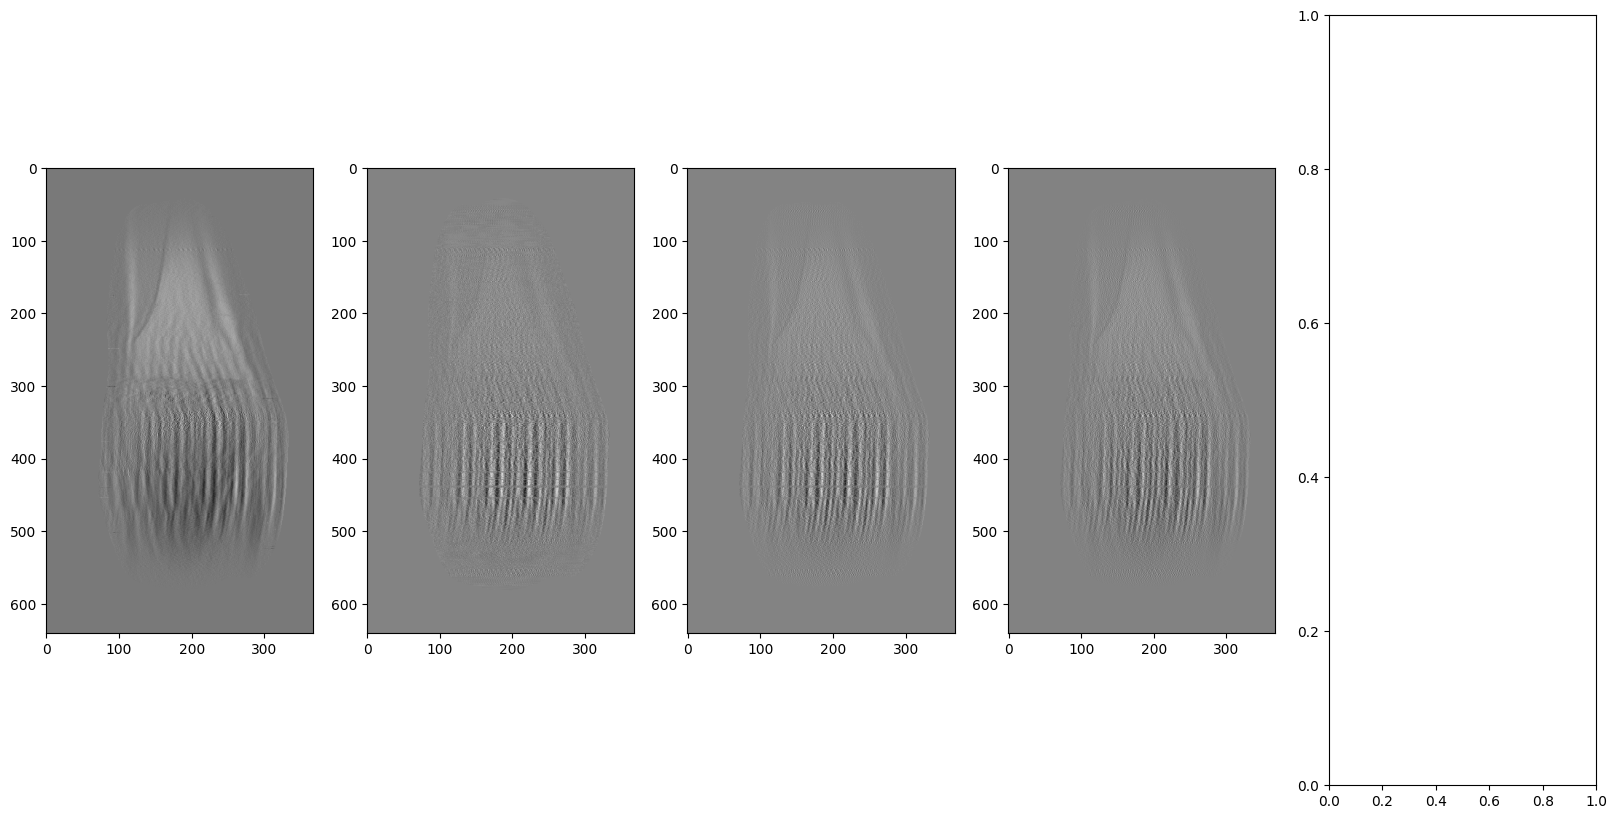

In [16]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(image, cmap="gray")